In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/seoul-bike-trip-duration-prediction/For_modeling.csv


In [2]:
from mpl_toolkits.mplot3d import Axes3D
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt # plotting
import numpy as np # linear algebra
import os # accessing directory structure
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import random
import seaborn as sns
from contextlib import contextmanager
from time import time
from tqdm import tqdm
import lightgbm as lgbm
from sklearn.metrics import classification_report, log_loss, accuracy_score
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold

In [3]:
df = pd.read_csv("../input/seoul-bike-trip-duration-prediction/For_modeling.csv")
df[0:6].T

0            1            2            3           4  \
Unnamed: 0    0.000000     1.000000     2.000000     3.000000    4.000000   
Duration      3.000000    24.000000     8.000000     8.000000    4.000000   
Distance     50.000000  7670.000000  1390.000000  1820.000000  850.000000   
PLong        37.544666    37.506199    37.544590    37.571102   37.573242   
PLatd       126.888359   127.003944   127.057083   127.023560  127.015907   
DLong        37.544666    37.551250    37.537014    37.561447   37.565849   
DLatd       126.888359   127.035103   127.061096   127.034920  127.016403   
Haversine     0.000000     5.713529     0.913702     1.468027    0.823227   
Pmonth        1.000000     1.000000     1.000000     1.000000    1.000000   
Pday          1.000000     1.000000     1.000000     1.000000    1.000000   
Phour         0.000000     0.000000     0.000000     0.000000    0.000000   
Pmin          0.000000     0.000000     0.000000     1.000000    1.000000   
PDweek        0.000000     0.000000     0.000000     0.000000    0.000000   
Dmonth        1.000000     1.000000     1.000000     1.000000    1.000000   
Dday          1.000000     1.000000     1.000000     1.000000    1.000000   
Dhour         0.000000     0.000000     0.000000     0.000000    0.000000   
Dmin          4.000000    25.000000     9.000000    10.000000    6.000000   
DDweek        0.000000     0.000000     0.000000     0.000000    0.000000   
Temp         -3.200000    -3.200000    -3.200000    -3.200000   -3.200000   
Precip        0.000000     0.000000     0.000000     0.000000    0.000000   
Wind          0.500000     0.500000     0.500000     0.500000    0.500000   
Humid        40.000000    40.000000    40.000000    40.000000   40.000000   
Solar         0.000000     0.000000     0.000000     0.000000    0.000000   
Snow          0.000000     0.000000     0.000000     0.000000    0.000000   
GroundTemp   -2.200000    -2.200000    -2.200000    -2.200000   -2.200000   
Dust         25.000000    25.000000    25.000000    25.000000   25.000000   

                      5  
Unnamed: 0     5.000000  
Duration       8.000000  
Distance    1800.000000  
PLong         37.571102  
PLatd        127.023560  
DLong         37.561447  
DLatd        127.034920  
Haversine      1.468027  
Pmonth         1.000000  
Pday           1.000000  
Phour          0.000000  
Pmin           1.000000  
PDweek         0.000000  
Dmonth         1.000000  
Dday           1.000000  
Dhour          0.000000  
Dmin          10.000000  
DDweek         0.000000  
Temp          -3.200000  
Precip         0.000000  
Wind           0.500000  
Humid         40.000000  
Solar          0.000000  
Snow           0.000000  
GroundTemp    -2.200000  
Dust          25.000000

In [4]:
df.shape

(9601139, 26)

In [5]:
df.drop('Unnamed: 0',
  axis='columns', inplace=True)

In [6]:
df.shape

(9601139, 25)

In [7]:
df.describe().apply(lambda s: s.apply(lambda x: format(x, 'g')))

Duration     Distance        PLong        PLatd        DLong  \
count  9.60114e+06  9.60114e+06  9.60114e+06  9.60114e+06  9.60114e+06   
mean       25.8029      3713.52      37.5476      126.991      37.5477   
std        25.0433      3956.61    0.0444138    0.0825707     0.044453   
min              1            1      37.4373      126.799      37.4373   
25%              8         1230      37.5142       126.92      37.5142   
50%             16         2280      37.5469      126.994      37.5465   
75%             36         4620      37.5732      127.062      37.5732   
max            119        33290      37.6897       127.18      37.6897   

             DLatd    Haversine       Pmonth         Pday        Phour  ...  \
count  9.60114e+06  9.60114e+06  9.60114e+06  9.60114e+06  9.60114e+06  ...   
mean       126.991      1.87031      7.57875      15.7671       14.378  ...   
std      0.0832373      1.99536       2.6968      8.74801      6.24924  ...   
min        126.799            0            1            1            0  ...   
25%        126.919     0.675867            6            8           10  ...   
50%        126.995       1.2575            8           16           16  ...   
75%        127.062      2.36381           10           23           19  ...   
max         127.18      28.6345           12           31           23  ...   

              Dmin       DDweek         Temp       Precip         Wind  \
count  9.60114e+06  9.60114e+06  9.60114e+06  9.60114e+06  9.60114e+06   
mean       29.9928      2.94577       18.562    0.0178486      1.81927   
std        17.3096      1.97762      9.49808     0.373628     0.971026   
min              0            0        -17.8            0            0   
25%             15            1         12.2            0          1.1   
50%             30            3         20.1            0          1.7   
75%             45            5         25.5            0          2.4   
max             59            6         39.4           35          7.4   

             Humid        Solar         Snow   GroundTemp         Dust  
count  9.60114e+06  9.60114e+06  9.60114e+06  9.60114e+06  9.60114e+06  
mean       53.9757     0.730068   0.00994892      20.7238       32.458  
std        17.4216       0.9175     0.162809      12.6522      24.0726  
min             10            0            0        -13.6            0  
25%             41            0            0         11.6           16  
50%             53         0.27            0         21.1           27  
75%             67         1.26            0         28.5           42  
max             98         3.52          8.8         62.2          304  

[8 rows x 25 columns]

In [8]:
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9601139 entries, 0 to 9601138
Data columns (total 25 columns):
 #   Column      Dtype  
---  ------      -----  
 0   Duration    int64  
 1   Distance    int64  
 2   PLong       float64
 3   PLatd       float64
 4   DLong       float64
 5   DLatd       float64
 6   Haversine   float64
 7   Pmonth      int64  
 8   Pday        int64  
 9   Phour       int64  
 10  Pmin        int64  
 11  PDweek      int64  
 12  Dmonth      int64  
 13  Dday        int64  
 14  Dhour       int64  
 15  Dmin        int64  
 16  DDweek      int64  
 17  Temp        float64
 18  Precip      float64
 19  Wind        float64
 20  Humid       float64
 21  Solar       float64
 22  Snow        float64
 23  GroundTemp  float64
 24  Dust        float64
dtypes: float64(13), int64(12)
memory usage: 1.8 GB


#### Univariate analysis

In [9]:
df.Duration.value_counts()

5      434870
6      431674
4      415106
7      410592
8      389080
        ...  
115     10900
116     10352
117      9851
118      8817
119      7685
Name: Duration, Length: 119, dtype: int64

In [10]:
df.nunique()

Duration         119
Distance        3385
PLong           1497
PLatd           1504
DLong           1501
DLatd           1508
Haversine     238583
Pmonth            12
Pday              31
Phour             24
Pmin              60
PDweek             7
Dmonth            12
Dday              31
Dhour             24
Dmin              60
DDweek             7
Temp             547
Precip            60
Wind              65
Humid             89
Solar            345
Snow              42
GroundTemp       700
Dust             163
dtype: int64

/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0.5, 1.0, 'Duration')

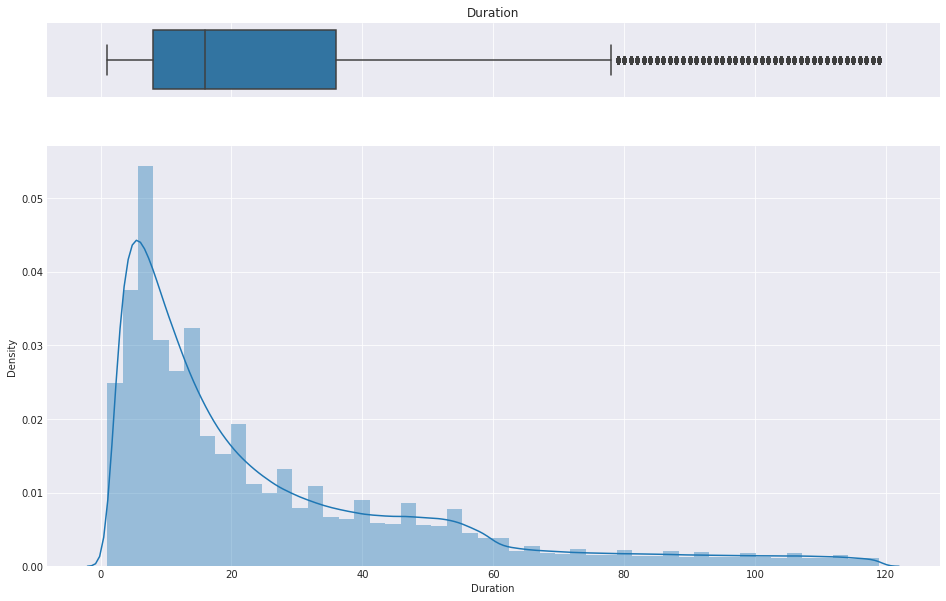

In [11]:
plt.style.use('seaborn-darkgrid')
                               
f, (ax_box, ax_hist) = plt.subplots(2, sharex=True, gridspec_kw={"height_ratios": (.15, .85)}, figsize=(16, 10))
sns.boxplot(df['Duration'],ax=ax_box)
sns.distplot(df['Duration'],ax=ax_hist)


# The abscissa of the box diagram is not displayed
ax_box.set(xlabel='')
ax_box.set_title('Duration')                                

{'whiskers': [<matplotlib.lines.Line2D at 0x7f64b90f2cd0>,
 'caps': [<matplotlib.lines.Line2D at 0x7f64b90fe590>,
 'boxes': [<matplotlib.lines.Line2D at 0x7f64b90f2990>],
 'medians': [<matplotlib.lines.Line2D at 0x7f64b90fee50>],
 'fliers': [<matplotlib.lines.Line2D at 0x7f64b910b2d0>],
 'means': []}

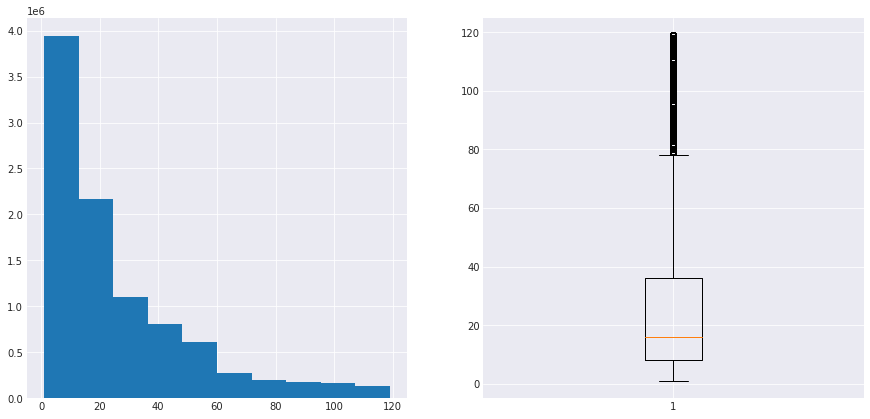

In [12]:
figs=plt.figure(figsize=(15,7))
ax1=figs.add_subplot(121)
ax2=figs.add_subplot(122)
x=df["Duration"]
ax1.hist(x)
ax2.boxplot(x)

In [13]:
df.Haversine.value_counts()

0.000000     955083
0.936970      13652
0.452993      10990
0.612179       8593
0.714991       8228
              ...  
15.545936         1
11.366423         1
5.792477          1
17.652135         1
2.838357          1
Name: Haversine, Length: 238583, dtype: int64

/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0.5, 1.0, 'Haversine')

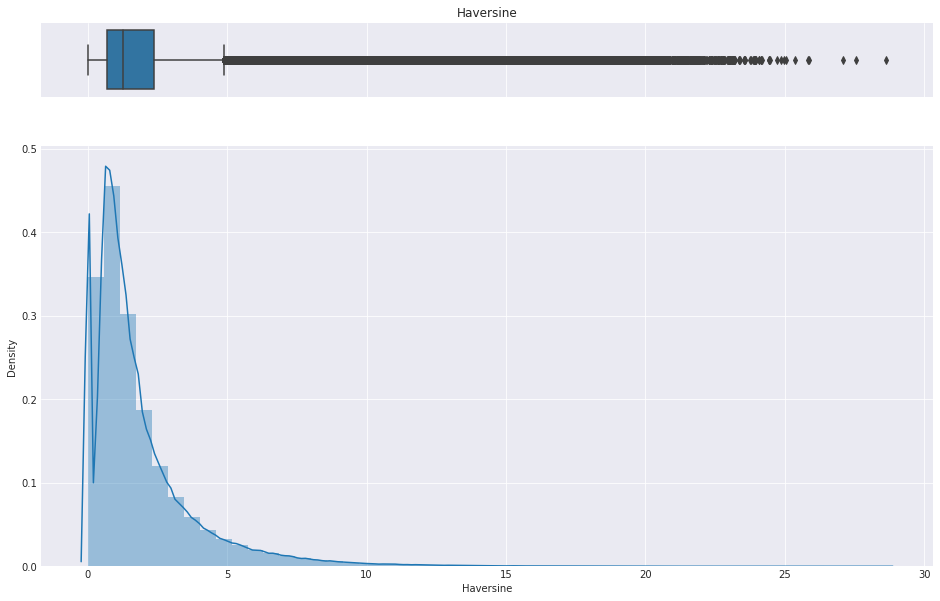

In [14]:
f, (ax_box, ax_hist) = plt.subplots(2, sharex=True, gridspec_kw={"height_ratios": (.15, .85)}, figsize=(16, 10))
sns.boxplot(df['Haversine'],ax=ax_box)
sns.distplot(df['Haversine'],ax=ax_hist)
# The abscissa of the box diagram is not displayed
ax_box.set(xlabel='')
ax_box.set_title('Haversine') 



{'whiskers': [<matplotlib.lines.Line2D at 0x7f64b8e94a90>,
 'caps': [<matplotlib.lines.Line2D at 0x7f64b8e9b350>,
 'boxes': [<matplotlib.lines.Line2D at 0x7f64b8e94710>],
 'medians': [<matplotlib.lines.Line2D at 0x7f64b8e9bc10>],
 'fliers': [<matplotlib.lines.Line2D at 0x7f64b8e26090>],
 'means': []}

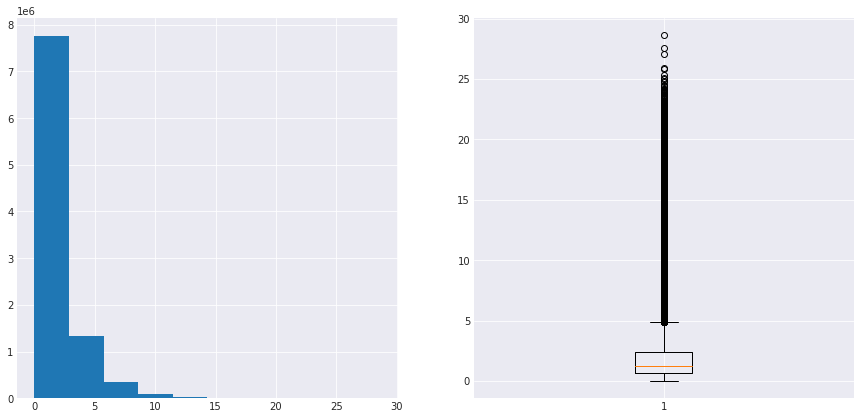

In [15]:
figs=plt.figure(figsize=(15,7))
ax1=figs.add_subplot(121)
ax2=figs.add_subplot(122)
x=df["Haversine"]
ax1.hist(x)
ax2.boxplot(x)

/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0.5, 1.0, 'Distance')

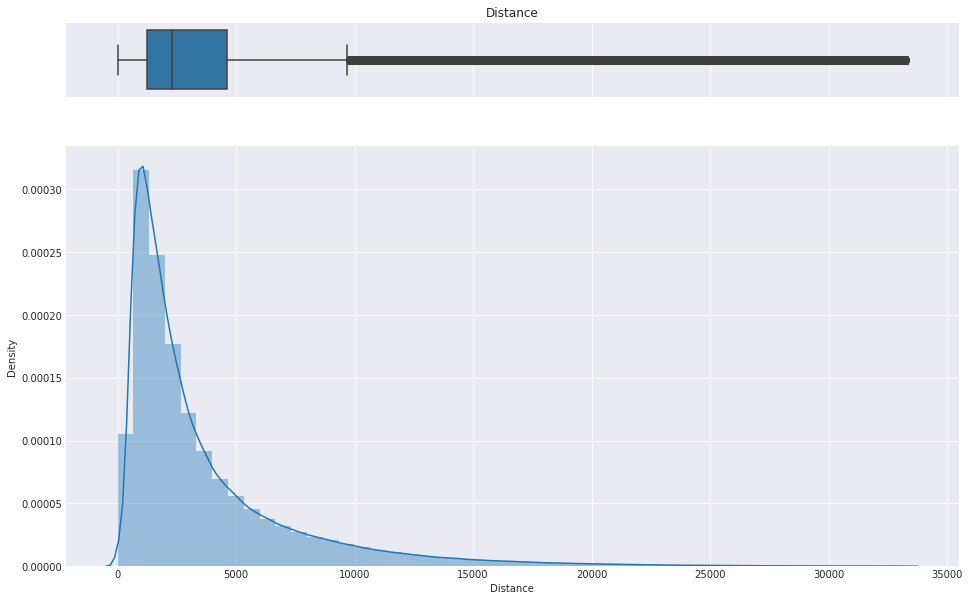

In [16]:
f, (ax_box, ax_hist) = plt.subplots(2, sharex=True, gridspec_kw={"height_ratios": (.15, .85)}, figsize=(16, 10))
sns.boxplot(df['Distance'],ax=ax_box)
sns.distplot(df['Distance'],ax=ax_hist)
# The abscissa of the box diagram is not displayed
ax_box.set(xlabel='')
ax_box.set_title('Distance') 


{'whiskers': [<matplotlib.lines.Line2D at 0x7f64b8baf4d0>,
 'caps': [<matplotlib.lines.Line2D at 0x7f64b8bafd50>,
 'boxes': [<matplotlib.lines.Line2D at 0x7f64b8baf150>],
 'medians': [<matplotlib.lines.Line2D at 0x7f64b8bbd650>],
 'fliers': [<matplotlib.lines.Line2D at 0x7f64b8bbda90>],
 'means': []}

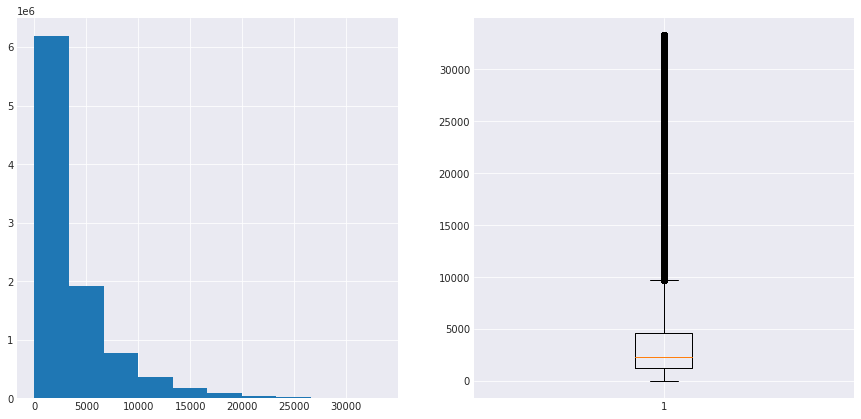

In [17]:

figs=plt.figure(figsize=(15,7))
ax1=figs.add_subplot(121)
ax2=figs.add_subplot(122)
x=df["Distance"]
ax1.hist(x)
ax2.boxplot(x)

/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0.5, 1.0, 'Temp')

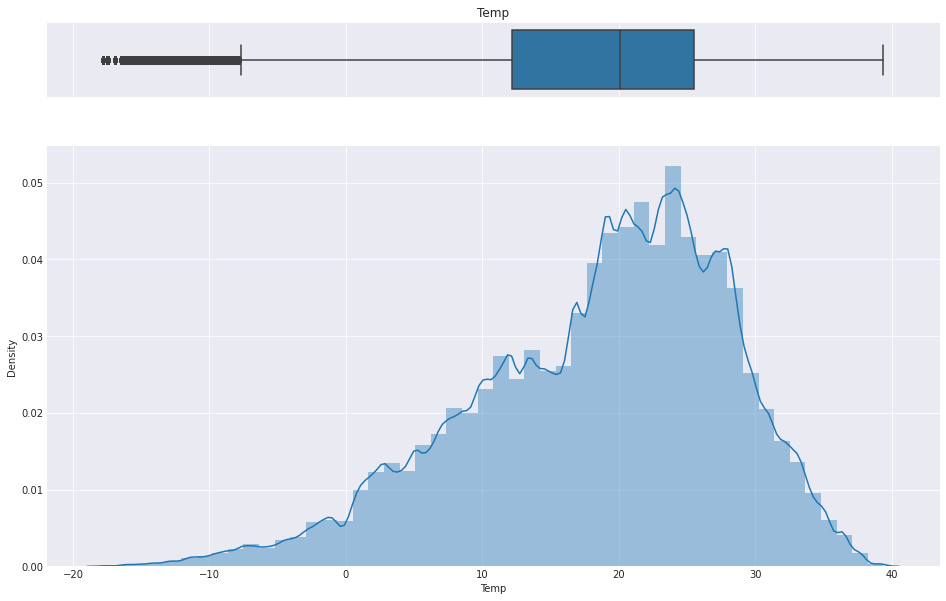

In [18]:
f, (ax_box, ax_hist) = plt.subplots(2, sharex=True, gridspec_kw={"height_ratios": (.15, .85)}, figsize=(16, 10))
sns.boxplot(df['Temp'],ax=ax_box)
sns.distplot(df['Temp'],ax=ax_hist)
# The abscissa of the box diagram is not displayed
ax_box.set(xlabel='')
ax_box.set_title('Temp') 


{'whiskers': [<matplotlib.lines.Line2D at 0x7f64b8926310>,
 'caps': [<matplotlib.lines.Line2D at 0x7f64b8926b90>,
 'boxes': [<matplotlib.lines.Line2D at 0x7f64b8998f50>],
 'medians': [<matplotlib.lines.Line2D at 0x7f64b8930490>],
 'fliers': [<matplotlib.lines.Line2D at 0x7f64b89308d0>],
 'means': []}

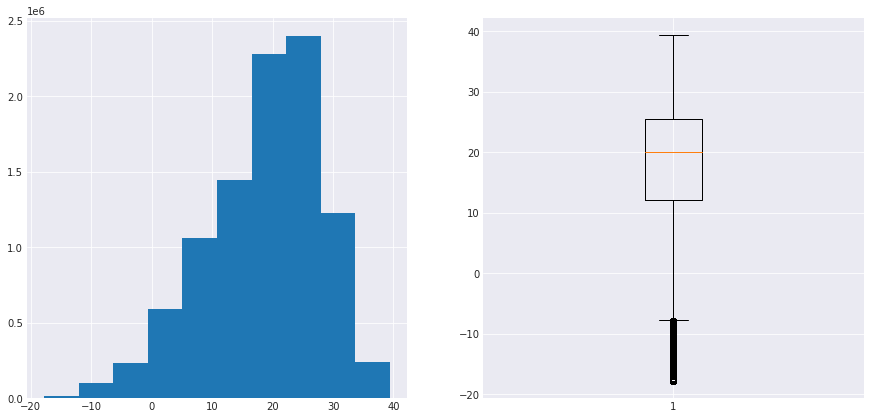

In [19]:

figs=plt.figure(figsize=(15,7))
ax1=figs.add_subplot(121)
ax2=figs.add_subplot(122)
x=df["Temp"]
ax1.hist(x)
ax2.boxplot(x)

/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0.5, 1.0, 'Precip')

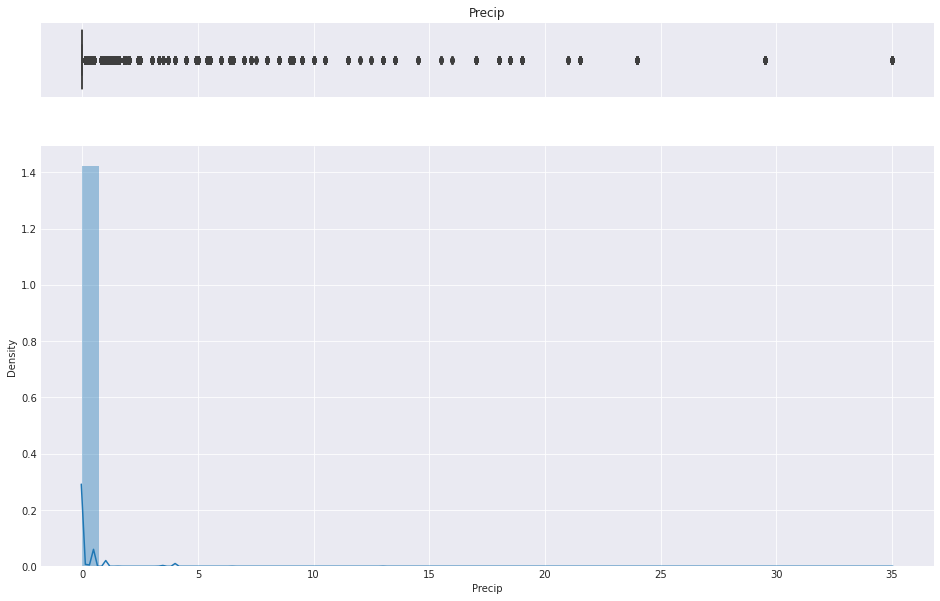

In [20]:
f, (ax_box, ax_hist) = plt.subplots(2, sharex=True, gridspec_kw={"height_ratios": (.15, .85)}, figsize=(16, 10))
sns.boxplot(df['Precip'],ax=ax_box)
sns.distplot(df['Precip'],ax=ax_hist)
# The abscissa of the box diagram is not displayed
ax_box.set(xlabel='')
ax_box.set_title('Precip') 



{'whiskers': [<matplotlib.lines.Line2D at 0x7f64b86b1110>,
 'caps': [<matplotlib.lines.Line2D at 0x7f64b86b1990>,
 'boxes': [<matplotlib.lines.Line2D at 0x7f64b86a7d50>],
 'medians': [<matplotlib.lines.Line2D at 0x7f64b86be290>],
 'fliers': [<matplotlib.lines.Line2D at 0x7f64b86be6d0>],
 'means': []}

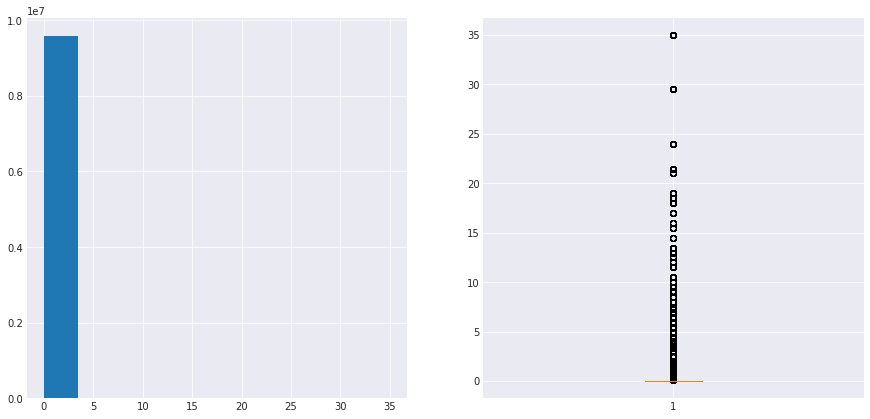

In [21]:
figs=plt.figure(figsize=(15,7))
ax1=figs.add_subplot(121)
ax2=figs.add_subplot(122)
x=df["Precip"]
ax1.hist(x)
ax2.boxplot(x)

/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0.5, 1.0, 'Wind')

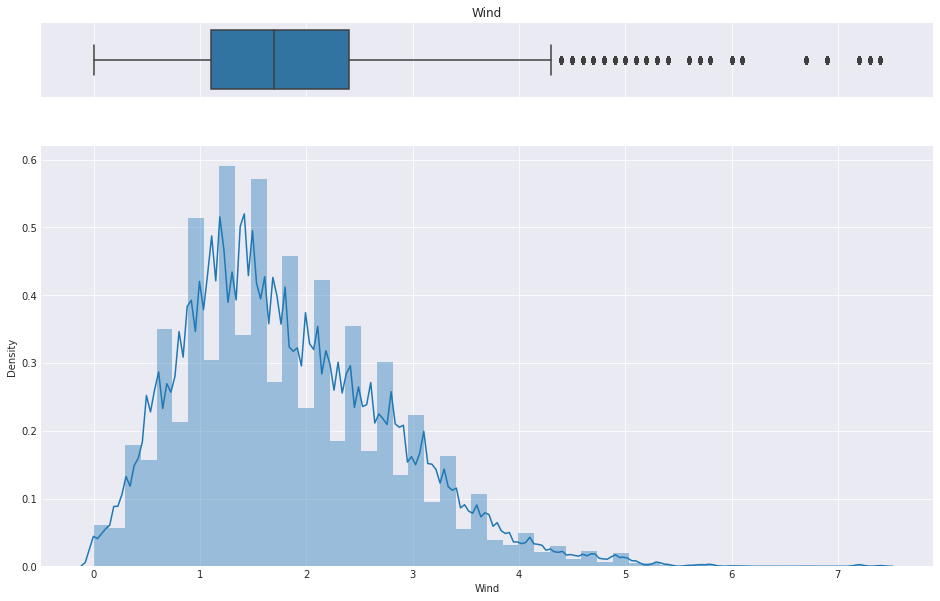

In [22]:
f, (ax_box, ax_hist) = plt.subplots(2, sharex=True, gridspec_kw={"height_ratios": (.15, .85)}, figsize=(16, 10))
sns.boxplot(df['Wind'],ax=ax_box)
sns.distplot(df['Wind'],ax=ax_hist)
# The abscissa of the box diagram is not displayed
ax_box.set(xlabel='')
ax_box.set_title('Wind') 



{'whiskers': [<matplotlib.lines.Line2D at 0x7f64b8448490>,
 'caps': [<matplotlib.lines.Line2D at 0x7f64b8448d10>,
 'boxes': [<matplotlib.lines.Line2D at 0x7f64b8448110>],
 'medians': [<matplotlib.lines.Line2D at 0x7f64b8455610>],
 'fliers': [<matplotlib.lines.Line2D at 0x7f64b8455a50>],
 'means': []}

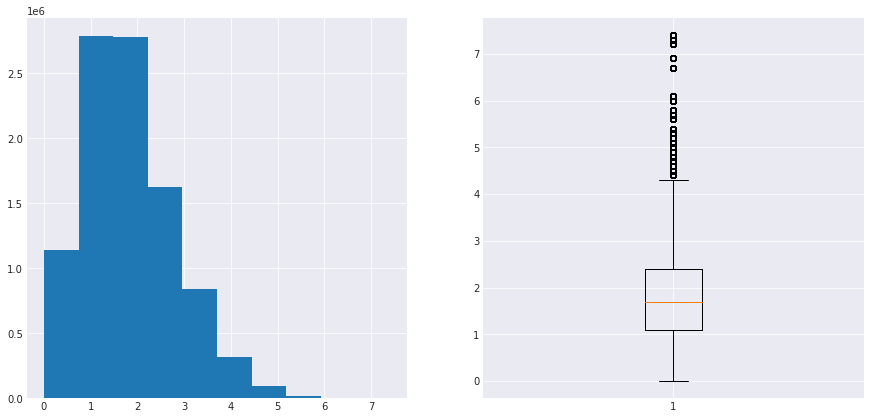

In [23]:
figs=plt.figure(figsize=(15,7))
ax1=figs.add_subplot(121)
ax2=figs.add_subplot(122)
x=df["Wind"]
ax1.hist(x)
ax2.boxplot(x)

/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0.5, 1.0, 'Humid')

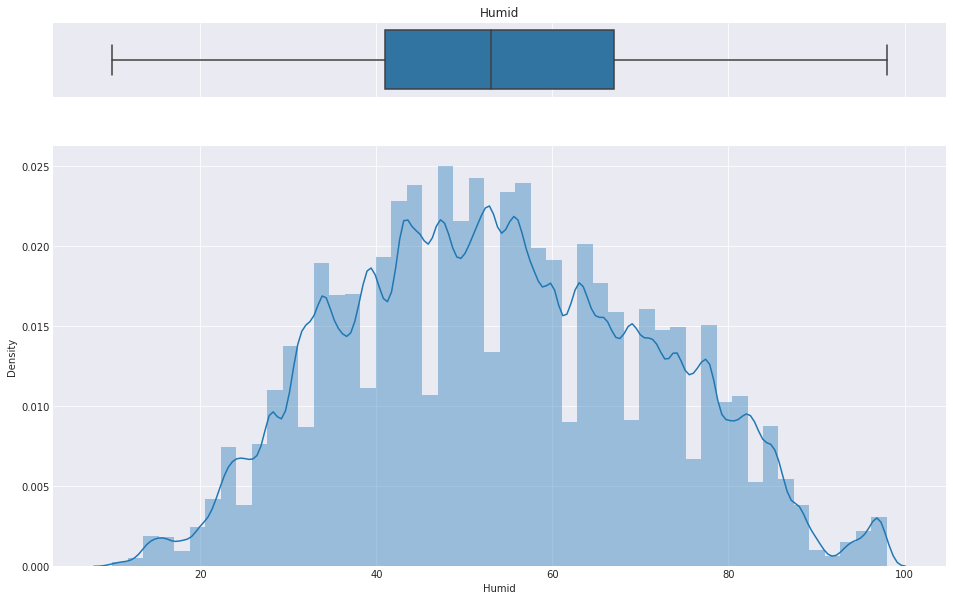

In [24]:
f, (ax_box, ax_hist) = plt.subplots(2, sharex=True, gridspec_kw={"height_ratios": (.15, .85)}, figsize=(16, 10))
sns.boxplot(df['Humid'],ax=ax_box)
sns.distplot(df['Humid'],ax=ax_hist)
# The abscissa of the box diagram is not displayed
ax_box.set(xlabel='')
ax_box.set_title('Humid') 



{'whiskers': [<matplotlib.lines.Line2D at 0x7f64b81c6990>,
 'caps': [<matplotlib.lines.Line2D at 0x7f64b81cf250>,
 'boxes': [<matplotlib.lines.Line2D at 0x7f64b81c6610>],
 'medians': [<matplotlib.lines.Line2D at 0x7f64b81cfb10>],
 'fliers': [<matplotlib.lines.Line2D at 0x7f64b81cff50>],
 'means': []}

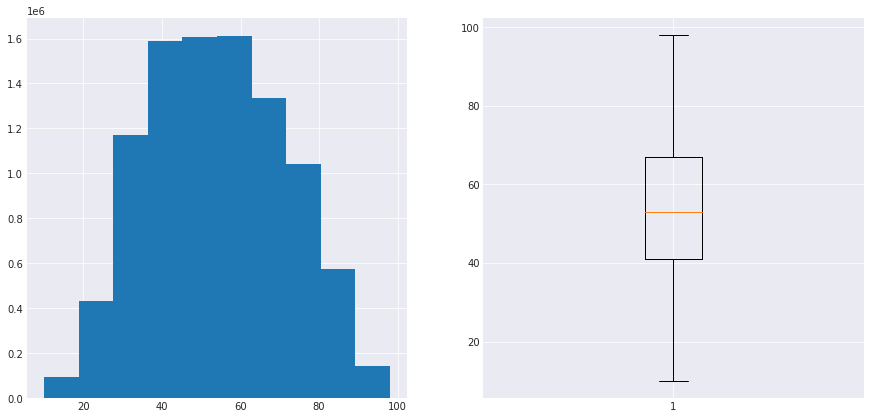

In [25]:
figs=plt.figure(figsize=(15,7))
ax1=figs.add_subplot(121)
ax2=figs.add_subplot(122)
x=df["Humid"]
ax1.hist(x)
ax2.boxplot(x)

/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0.5, 1.0, 'Solar')

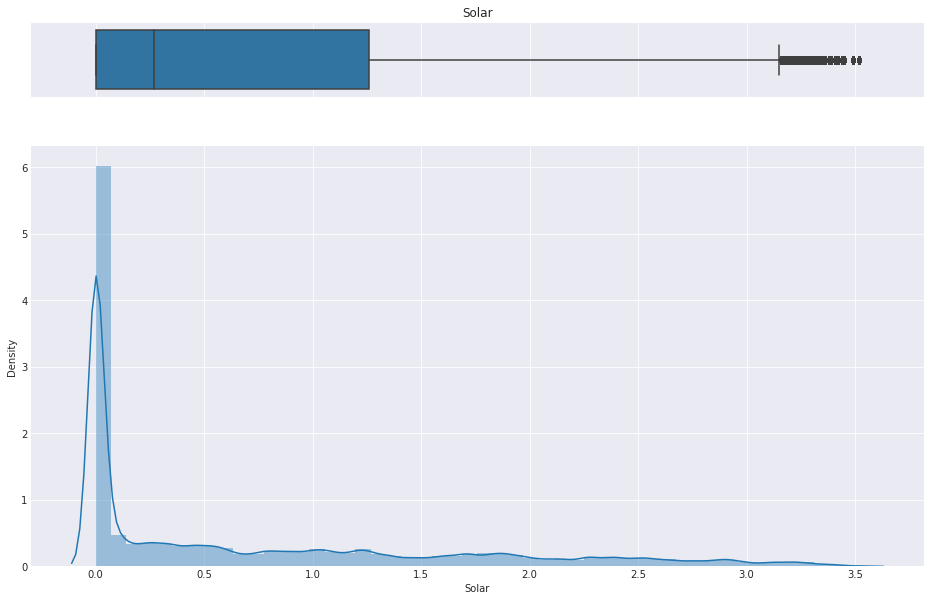

In [26]:
f, (ax_box, ax_hist) = plt.subplots(2, sharex=True, gridspec_kw={"height_ratios": (.15, .85)}, figsize=(16, 10))
sns.boxplot(df['Solar'],ax=ax_box)
sns.distplot(df['Solar'],ax=ax_hist)
# The abscissa of the box diagram is not displayed
ax_box.set(xlabel='')
ax_box.set_title('Solar') 



{'whiskers': [<matplotlib.lines.Line2D at 0x7f64b7f53c10>,
 'caps': [<matplotlib.lines.Line2D at 0x7f64b7f5b4d0>,
 'boxes': [<matplotlib.lines.Line2D at 0x7f64b7f53890>],
 'medians': [<matplotlib.lines.Line2D at 0x7f64b7f5bd90>],
 'fliers': [<matplotlib.lines.Line2D at 0x7f64b7ee8210>],
 'means': []}

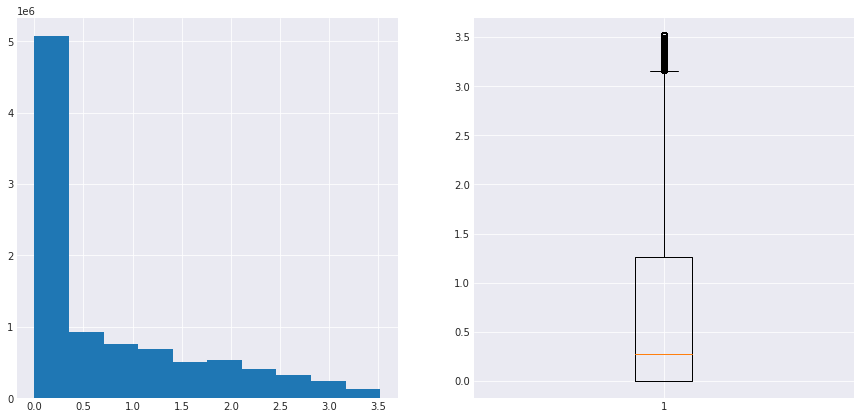

In [27]:
figs=plt.figure(figsize=(15,7))
ax1=figs.add_subplot(121)
ax2=figs.add_subplot(122)
x=df["Solar"]
ax1.hist(x)
ax2.boxplot(x)

/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0.5, 1.0, 'Snow')

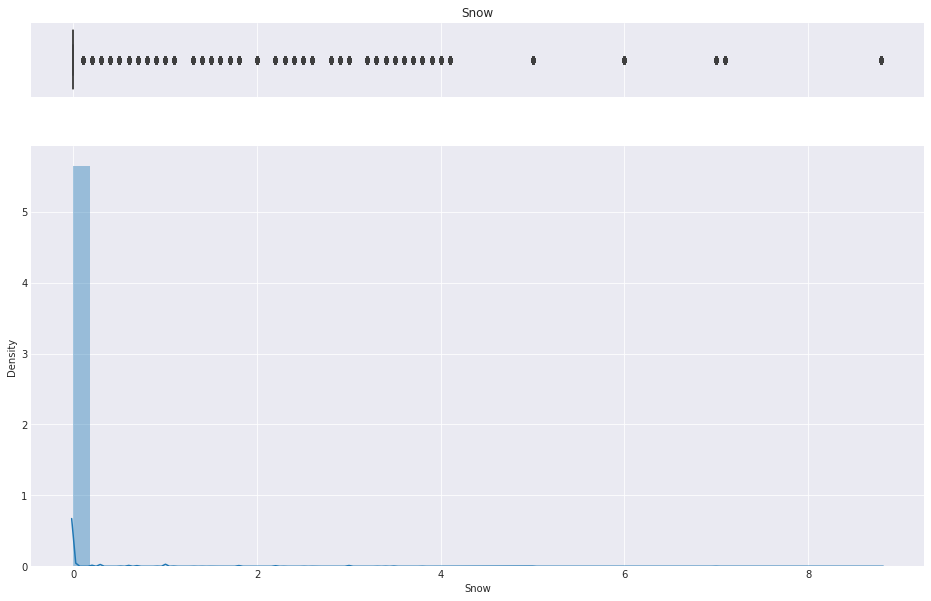

In [28]:
f, (ax_box, ax_hist) = plt.subplots(2, sharex=True, gridspec_kw={"height_ratios": (.15, .85)}, figsize=(16, 10))
sns.boxplot(df['Snow'],ax=ax_box)
sns.distplot(df['Snow'],ax=ax_hist)
# The abscissa of the box diagram is not displayed
ax_box.set(xlabel='')
ax_box.set_title('Snow') 



{'whiskers': [<matplotlib.lines.Line2D at 0x7f64b33721d0>,
 'caps': [<matplotlib.lines.Line2D at 0x7f64b3372a50>,
 'boxes': [<matplotlib.lines.Line2D at 0x7f64b3367e10>],
 'medians': [<matplotlib.lines.Line2D at 0x7f64b337c350>],
 'fliers': [<matplotlib.lines.Line2D at 0x7f64b337c790>],
 'means': []}

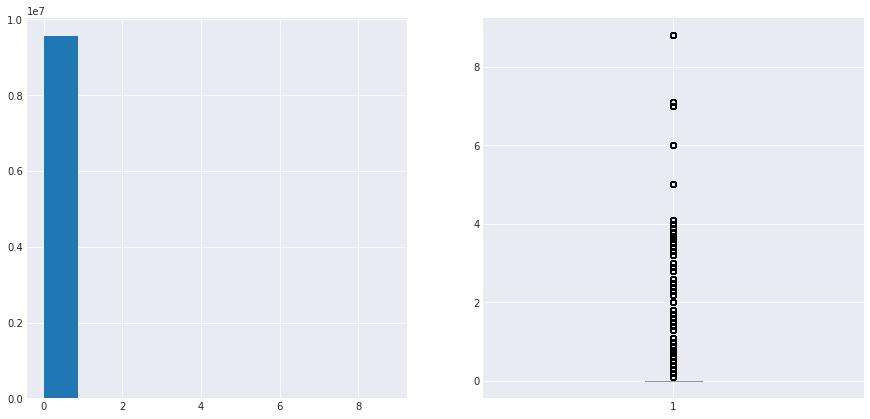

In [29]:
figs=plt.figure(figsize=(15,7))
ax1=figs.add_subplot(121)
ax2=figs.add_subplot(122)
x=df["Snow"]
ax1.hist(x)
ax2.boxplot(x)

/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0.5, 1.0, 'GroundTemp')

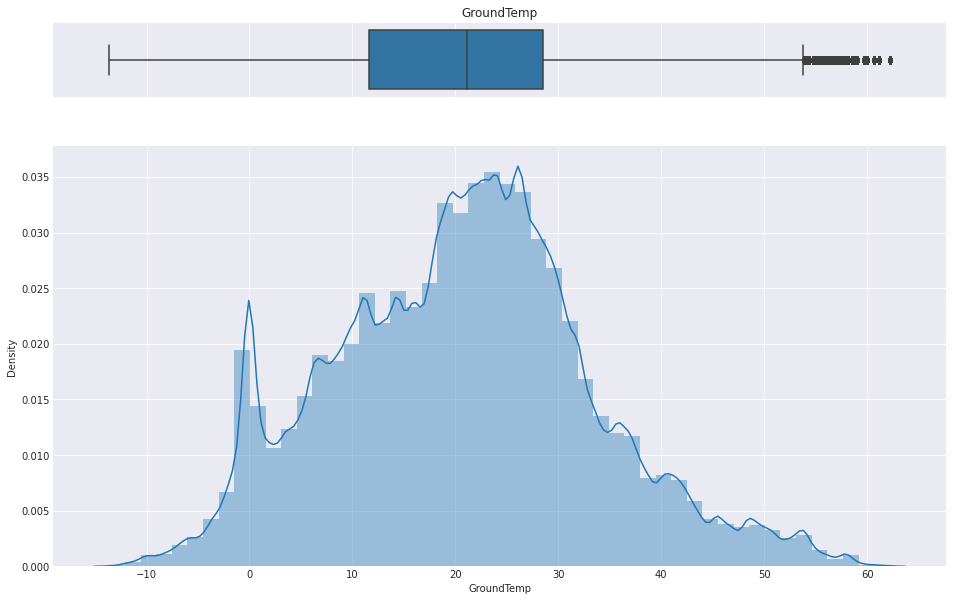

In [30]:
f, (ax_box, ax_hist) = plt.subplots(2, sharex=True, gridspec_kw={"height_ratios": (.15, .85)}, figsize=(16, 10))
sns.boxplot(df['GroundTemp'],ax=ax_box)
sns.distplot(df['GroundTemp'],ax=ax_hist)
# The abscissa of the box diagram is not displayed
ax_box.set(xlabel='')
ax_box.set_title('GroundTemp') 



{'whiskers': [<matplotlib.lines.Line2D at 0x7f64b30e15d0>,
 'caps': [<matplotlib.lines.Line2D at 0x7f64b30e1e50>,
 'boxes': [<matplotlib.lines.Line2D at 0x7f64b30e1250>],
 'medians': [<matplotlib.lines.Line2D at 0x7f64b30eb750>],
 'fliers': [<matplotlib.lines.Line2D at 0x7f64b30ebb90>],
 'means': []}

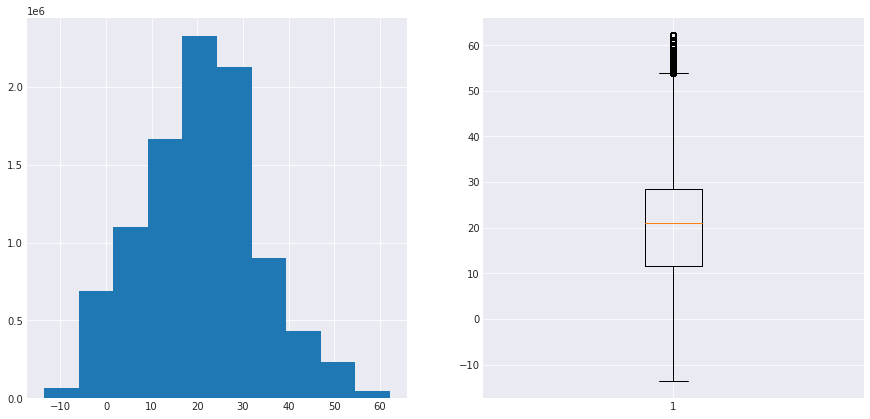

In [31]:
figs=plt.figure(figsize=(15,7))
ax1=figs.add_subplot(121)
ax2=figs.add_subplot(122)
x=df["GroundTemp"]
ax1.hist(x)
ax2.boxplot(x)

/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0.5, 1.0, 'Dust')

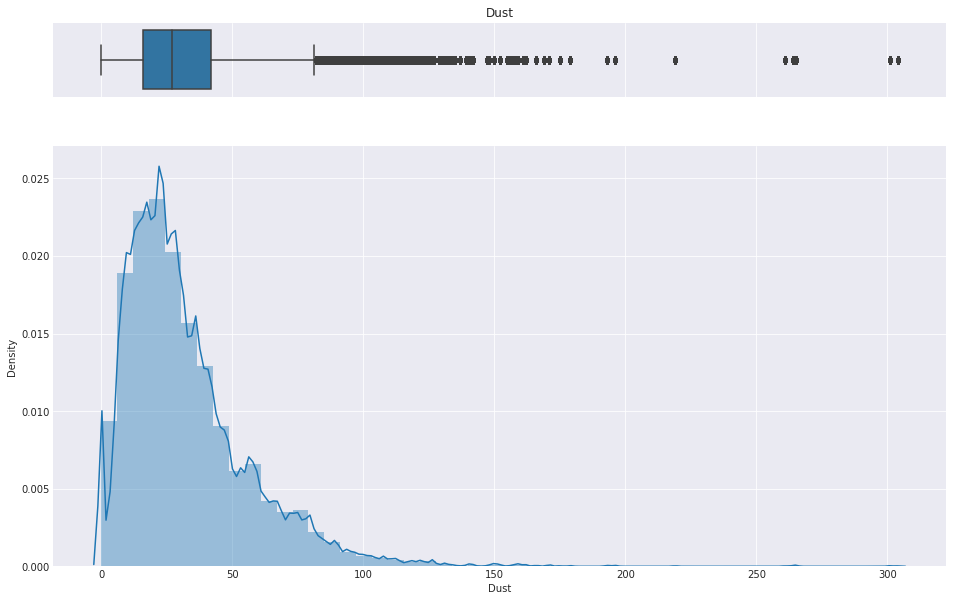

In [32]:
f, (ax_box, ax_hist) = plt.subplots(2, sharex=True, gridspec_kw={"height_ratios": (.15, .85)}, figsize=(16, 10))
sns.boxplot(df['Dust'],ax=ax_box)
sns.distplot(df['Dust'],ax=ax_hist)
# The abscissa of the box diagram is not displayed
ax_box.set(xlabel='')
ax_box.set_title('Dust') 



{'whiskers': [<matplotlib.lines.Line2D at 0x7f64b2e68190>,
 'caps': [<matplotlib.lines.Line2D at 0x7f64b2e68a10>,
 'boxes': [<matplotlib.lines.Line2D at 0x7f64b2edfdd0>],
 'medians': [<matplotlib.lines.Line2D at 0x7f64b2e72310>],
 'fliers': [<matplotlib.lines.Line2D at 0x7f64b2e72750>],
 'means': []}

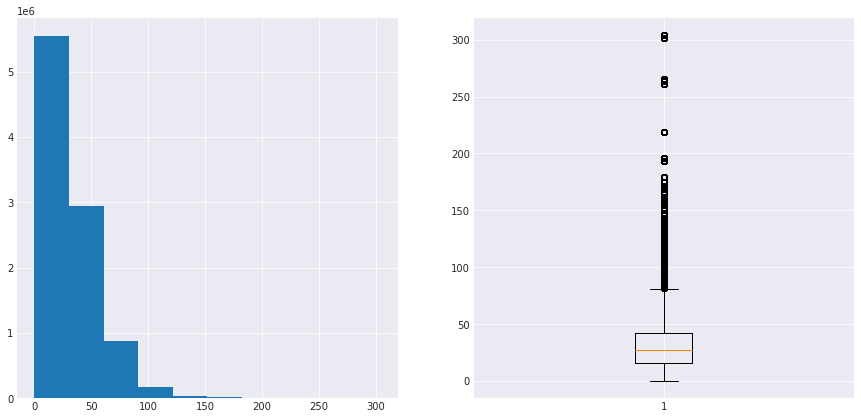

In [33]:
figs=plt.figure(figsize=(15,7))
ax1=figs.add_subplot(121)
ax2=figs.add_subplot(122)
x=df["Dust"]
ax1.hist(x)
ax2.boxplot(x)

In [34]:
### Bivariate Analysis

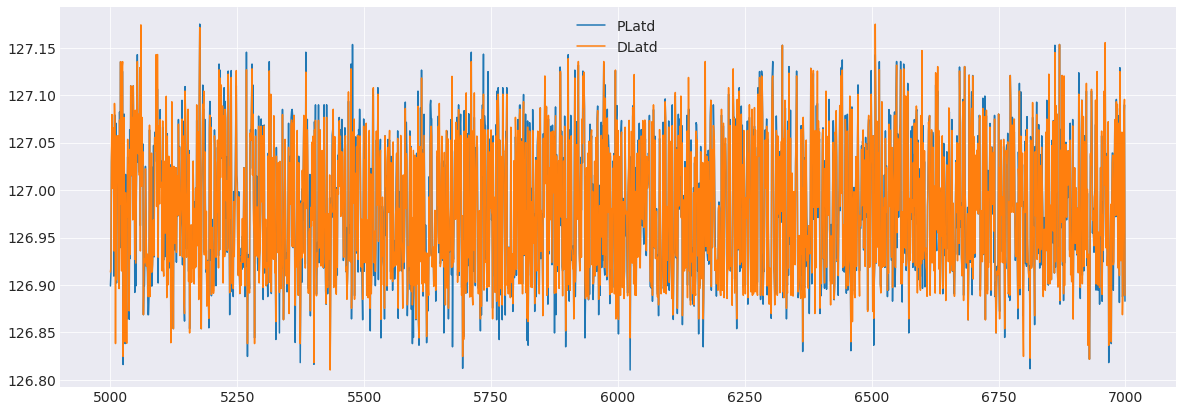

In [35]:
plt.figure(figsize=(20,7))
plt.rc('font',size=14)
plt.plot(df['PLatd'][5000:7000],label='PLatd')
plt.plot(df['DLatd'][5000:7000],label='DLatd')
plt.legend()
plt.show()

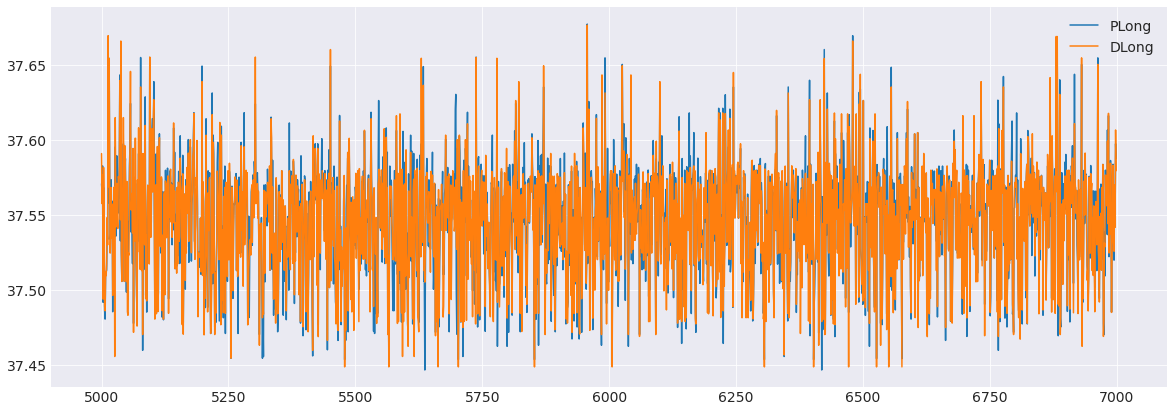

In [36]:
plt.figure(figsize=(20,7))
plt.rc('font',size=14)
plt.plot(df['PLong'][5000:7000],label='PLong')
plt.plot(df['DLong'][5000:7000],label='DLong')
plt.legend()
plt.show()

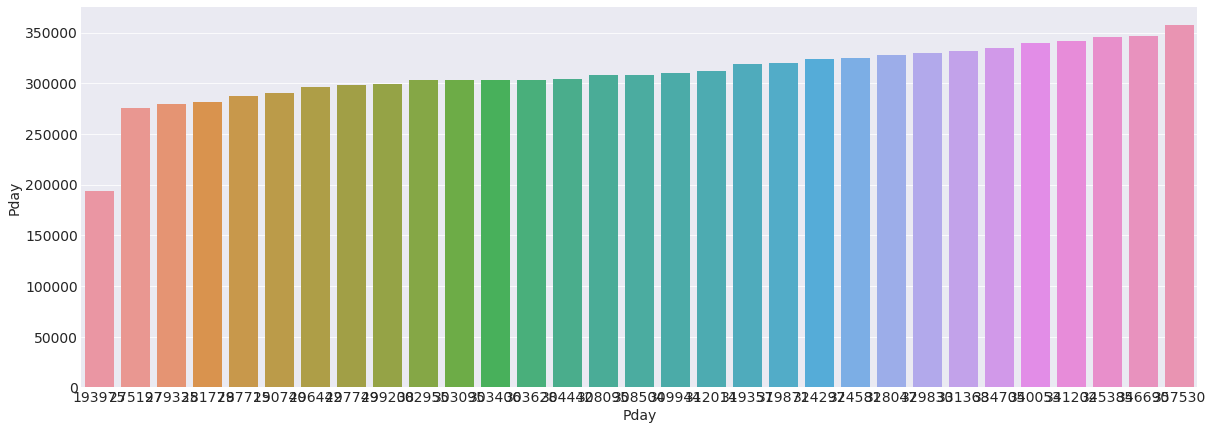

In [37]:
plt.figure(figsize=(20,7))
plt.rc('font',size=14)
sns.barplot(y=df.Pday.value_counts(),x=df.Pday.value_counts())
plt.show()

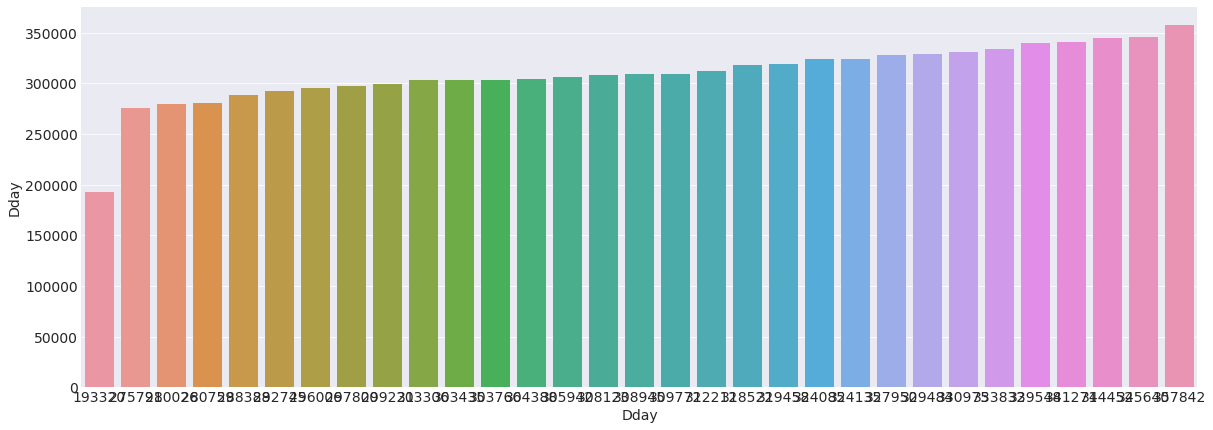

In [38]:
plt.figure(figsize=(20,7))
plt.rc('font',size=14)
sns.barplot(y=df.Dday.value_counts(),x=df.Dday.value_counts())
plt.show()

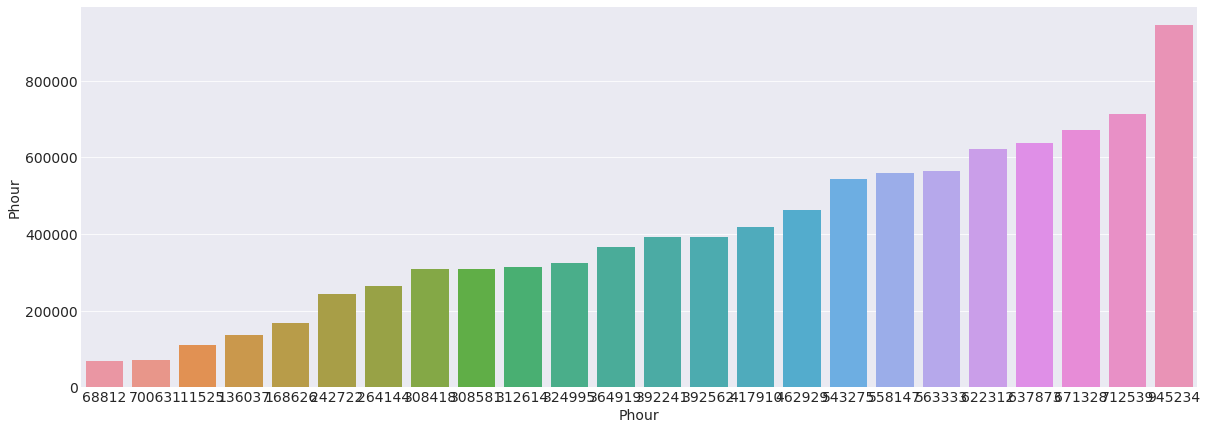

In [39]:
plt.figure(figsize=(20,7))
plt.rc('font',size=14)
sns.barplot(y=df.Phour.value_counts(),x=df.Phour.value_counts())
plt.show()

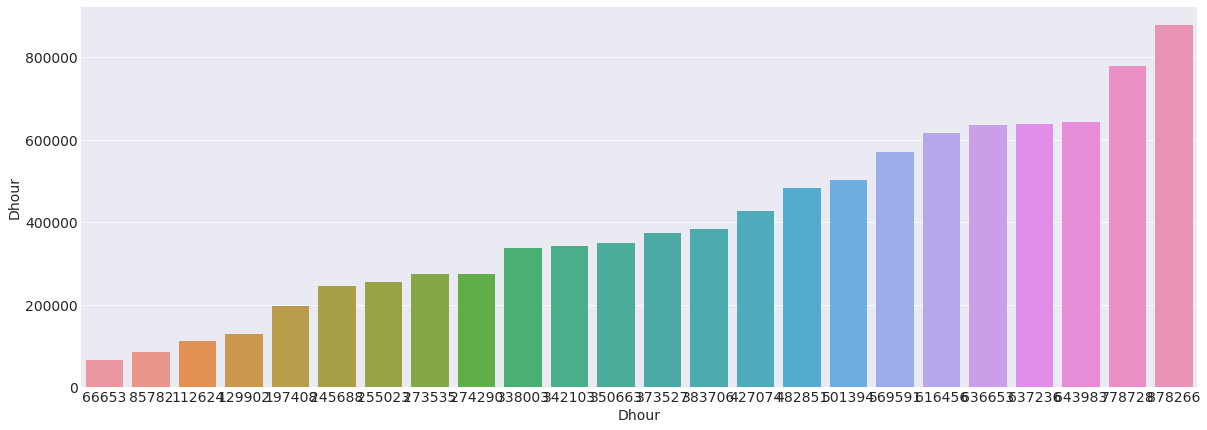

In [40]:
plt.figure(figsize=(20,7))
plt.rc('font',size=14)
sns.barplot(y=df.Dhour.value_counts(),x=df.Dhour.value_counts())
plt.show()

### Inference: Lot of column have 0 values

In [41]:
(df==0).sum()

Duration            0
Distance            0
PLong               0
PLatd               0
DLong               0
DLatd               0
Haversine      955083
Pmonth              0
Pday                0
Phour          312614
Pmin           151097
PDweek        1368433
Dmonth              0
Dday                0
Dhour          350663
Dmin           157305
DDweek        1367274
Temp             2857
Precip        9485238
Wind            39987
Humid               0
Solar         3439939
Snow          9531693
GroundTemp      53281
Dust           237024
dtype: int64

In [42]:
print(df['PLatd'][1])
print(df['PLong'][1])
print(df['DLatd'][1])
print(df['DLong'][1])

127.003944
37.506199
127.035103
37.55125


In [43]:
df.columns

Index(['Duration', 'Distance', 'PLong', 'PLatd', 'DLong', 'DLatd', 'Haversine',
       'Pmonth', 'Pday', 'Phour', 'Pmin', 'PDweek', 'Dmonth', 'Dday', 'Dhour',
       'Dmin', 'DDweek', 'Temp', 'Precip', 'Wind', 'Humid', 'Solar', 'Snow',
       'GroundTemp', 'Dust'],
      dtype='object')

In [44]:
df[['PLatd','PLong']]=df[['PLong','PLatd']]
df[['DLatd','DLong']]=df[['DLong','DLatd']]
df.head()

Duration  Distance       PLong      PLatd       DLong      DLatd  \
0         3        50  126.888359  37.544666  126.888359  37.544666   
1        24      7670  127.003944  37.506199  127.035103  37.551250   
2         8      1390  127.057083  37.544590  127.061096  37.537014   
3         8      1820  127.023560  37.571102  127.034920  37.561447   
4         4       850  127.015907  37.573242  127.016403  37.565849   

   Haversine  Pmonth  Pday  Phour  ...  Dmin  DDweek  Temp  Precip  Wind  \
0   0.000000       1     1      0  ...     4       0  -3.2     0.0   0.5   
1   5.713529       1     1      0  ...    25       0  -3.2     0.0   0.5   
2   0.913702       1     1      0  ...     9       0  -3.2     0.0   0.5   
3   1.468027       1     1      0  ...    10       0  -3.2     0.0   0.5   
4   0.823227       1     1      0  ...     6       0  -3.2     0.0   0.5   

   Humid  Solar  Snow  GroundTemp  Dust  
0   40.0    0.0   0.0        -2.2  25.0  
1   40.0    0.0   0.0        -2.2  25.0  
2   40.0    0.0   0.0        -2.2  25.0  
3   40.0    0.0   0.0        -2.2  25.0  
4   40.0    0.0   0.0        -2.2  25.0  

[5 rows x 25 columns]

In [45]:
from math import radians, cos, sin, asin, sqrt
def calc_haversine(lon1,lat1,lon2,lat2,is_deg=True):
# convert decimal degreesto radians
    if is_deg:
        lon1,lat1,lon2,lat2=map(radians,[lon1,lat1,lon2,lat2])
    dlon=lon2-lon1
    dlat=lat2-lat1
                          
    a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
    c = 2 * asin(sqrt(a)) 
    km=6371*c
    return km
d=df['Haversine'][1]
plat=df['PLatd'][1]
plon=df['PLong'][1]
dlat=df['DLatd'][1]
dlon=df['DLong'][1]
print(d)
calc_haversine(plon,plat,dlon,dlat)

5.713528999751687


5.713521107899132

### Preprocessing

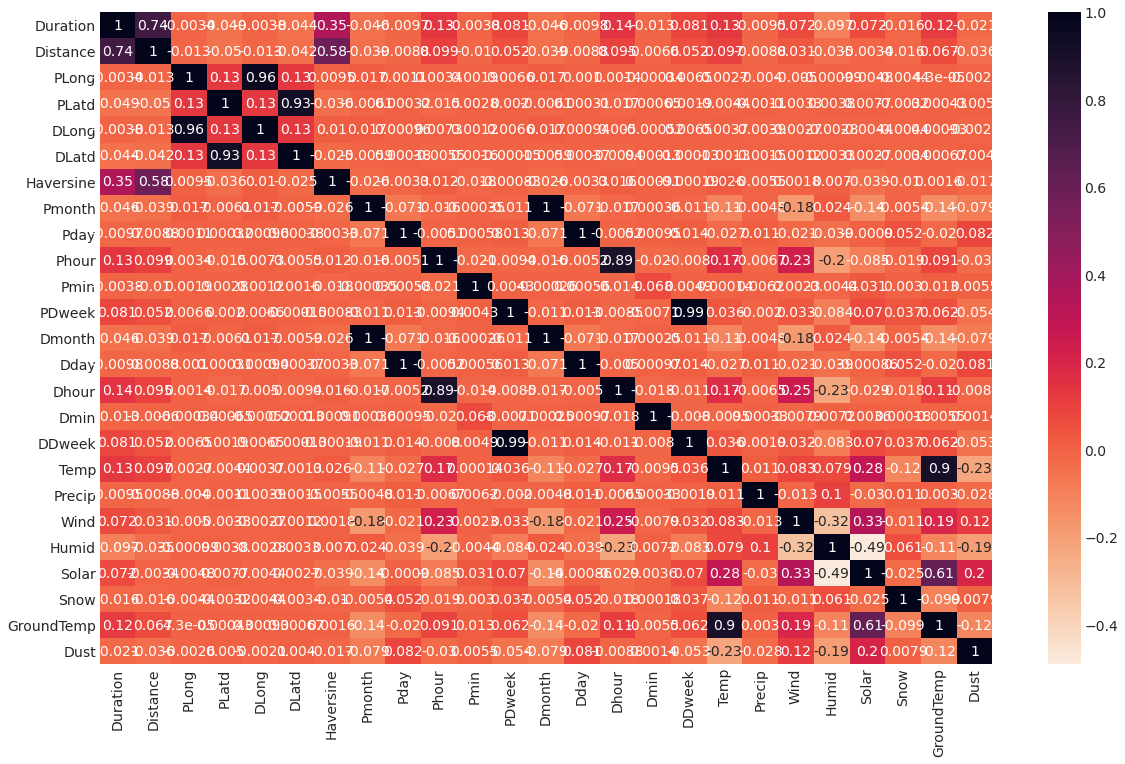

In [46]:
plt.figure(figsize=(20,12))
sns.heatmap(df.corr(),cmap='rocket_r',annot=True)
plt.show()

In [47]:
df.reset_index(drop=True,inplace=True)
df.tail()

Duration  Distance       PLong      PLatd       DLong      DLatd  \
9601134        67      6930  127.051308  37.562607  127.051308  37.562607   
9601135        58      8320  127.085052  37.511982  127.105942  37.476028   
9601136       118      2730  127.003944  37.506199  127.015282  37.514870   
9601137        90     17170  126.927467  37.489750  126.901184  37.565903   
9601138       116      1410  127.075050  37.585655  127.075050  37.585655   

         Haversine  Pmonth  Pday  Phour  ...  Dmin  DDweek  Temp  Precip  \
9601134   0.000000      12    31     23  ...    51       1  -5.2     0.0   
9601135   4.402263      12    31     23  ...    53       1  -5.2     0.0   
9601136   1.389156      12    31     22  ...    58       1  -5.4     0.0   
9601137   8.779307      12    31     23  ...    26       1  -5.2     0.0   
9601138   0.000000      12    31     23  ...    30       1  -5.2     0.0   

         Wind  Humid  Solar  Snow  GroundTemp  Dust  
9601134   1.6   47.0    0.0   0.0        -5.1  53.0  
9601135   1.6   47.0    0.0   0.0        -5.1  53.0  
9601136   1.3   46.0    0.0   0.0        -5.0  49.0  
9601137   1.6   47.0    0.0   0.0        -5.1  53.0  
9601138   1.6   47.0    0.0   0.0        -5.1  53.0  

[5 rows x 25 columns]

In [48]:
ids=list(np.where(df['Haversine']==0.00)[0])
len(ids)

955083

In [49]:
for s in ids[:10]:
    print(calc_haversine(df['PLong'][s],df['PLatd'][s],df['DLong'][s],df['DLatd'][s]))

0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0


In [50]:
df.drop(labels=['Snow','Precip','PLatd','PLong','DLatd','DLong'],axis=1,inplace=True)
df=df.loc[df['Dust']*df['Wind']*df['Haversine']*df['Solar']!=0]
df.reset_index(drop=True,inplace=True)

In [51]:
df.tail()

Duration  Distance  Haversine  Pmonth  Pday  Phour  Pmin  PDweek  \
5360942        87      1370   0.708871      12    31     18    46       0   
5360943        84      2480   1.805493      12    31     18    53       0   
5360944       104     19000   6.492618      12    31     18    35       0   
5360945       101      2680   0.896676      12    31     18    48       0   
5360946       113      9390   4.064093      12    31     18    52       0   

         Dmonth  Dday  Dhour  Dmin  DDweek  Temp  Wind  Humid  Solar  \
5360942      12    31     20    14       0  -2.4   1.7   27.0   0.02   
5360943      12    31     20    19       0  -2.4   1.7   27.0   0.02   
5360944      12    31     20    20       0  -2.4   1.7   27.0   0.02   
5360945      12    31     20    30       0  -2.4   1.7   27.0   0.02   
5360946      12    31     20    51       0  -2.4   1.7   27.0   0.02   

         GroundTemp  Dust  
5360942        -1.4  49.0  
5360943        -1.4  49.0  
5360944        -1.4  49.0  
5360945        -1.4  49.0  
5360946        -1.4  49.0

In [52]:
df.drop(labels=['Dday','Dmonth','DDweek'],axis=1,inplace=True)
df.tail()

Duration  Distance  Haversine  Pmonth  Pday  Phour  Pmin  PDweek  \
5360942        87      1370   0.708871      12    31     18    46       0   
5360943        84      2480   1.805493      12    31     18    53       0   
5360944       104     19000   6.492618      12    31     18    35       0   
5360945       101      2680   0.896676      12    31     18    48       0   
5360946       113      9390   4.064093      12    31     18    52       0   

         Dhour  Dmin  Temp  Wind  Humid  Solar  GroundTemp  Dust  
5360942     20    14  -2.4   1.7   27.0   0.02        -1.4  49.0  
5360943     20    19  -2.4   1.7   27.0   0.02        -1.4  49.0  
5360944     20    20  -2.4   1.7   27.0   0.02        -1.4  49.0  
5360945     20    30  -2.4   1.7   27.0   0.02        -1.4  49.0  
5360946     20    51  -2.4   1.7   27.0   0.02        -1.4  49.0

## Multivariate Analysis

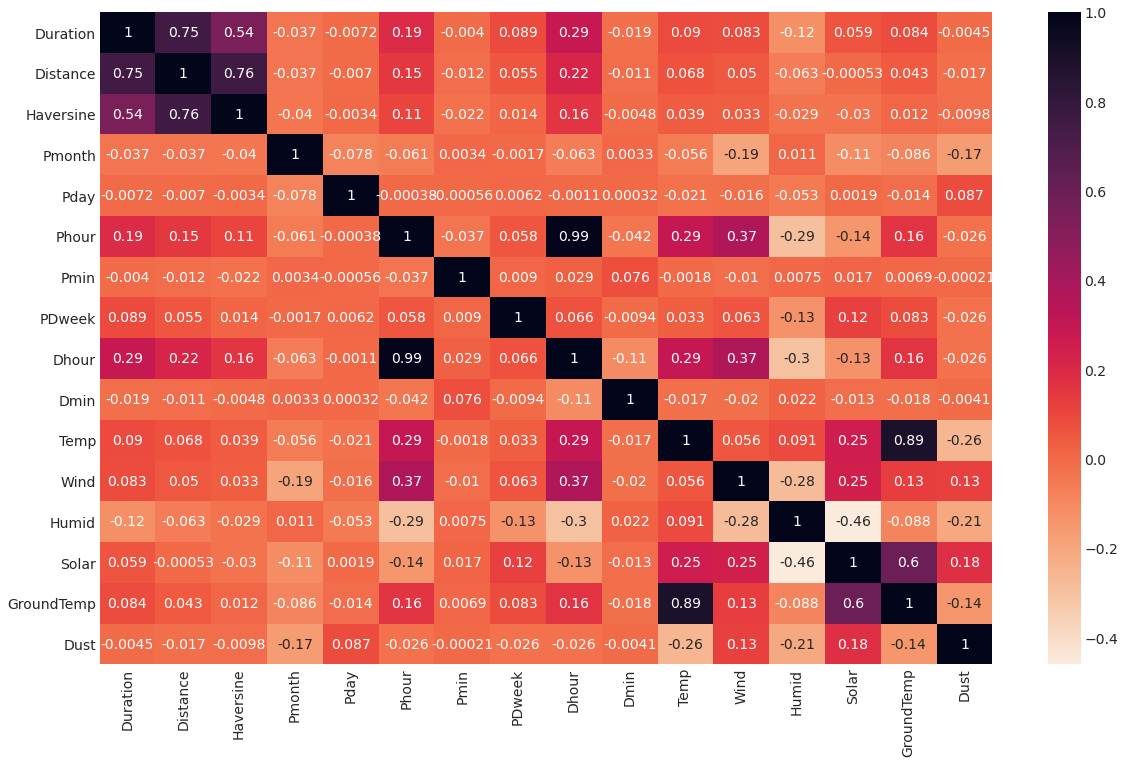

In [53]:
plt.figure(figsize=(20,12))
sns.heatmap(df.corr(),cmap='rocket_r',annot=True)
plt.show()

In [54]:
sampling=df.sample(n=10000)

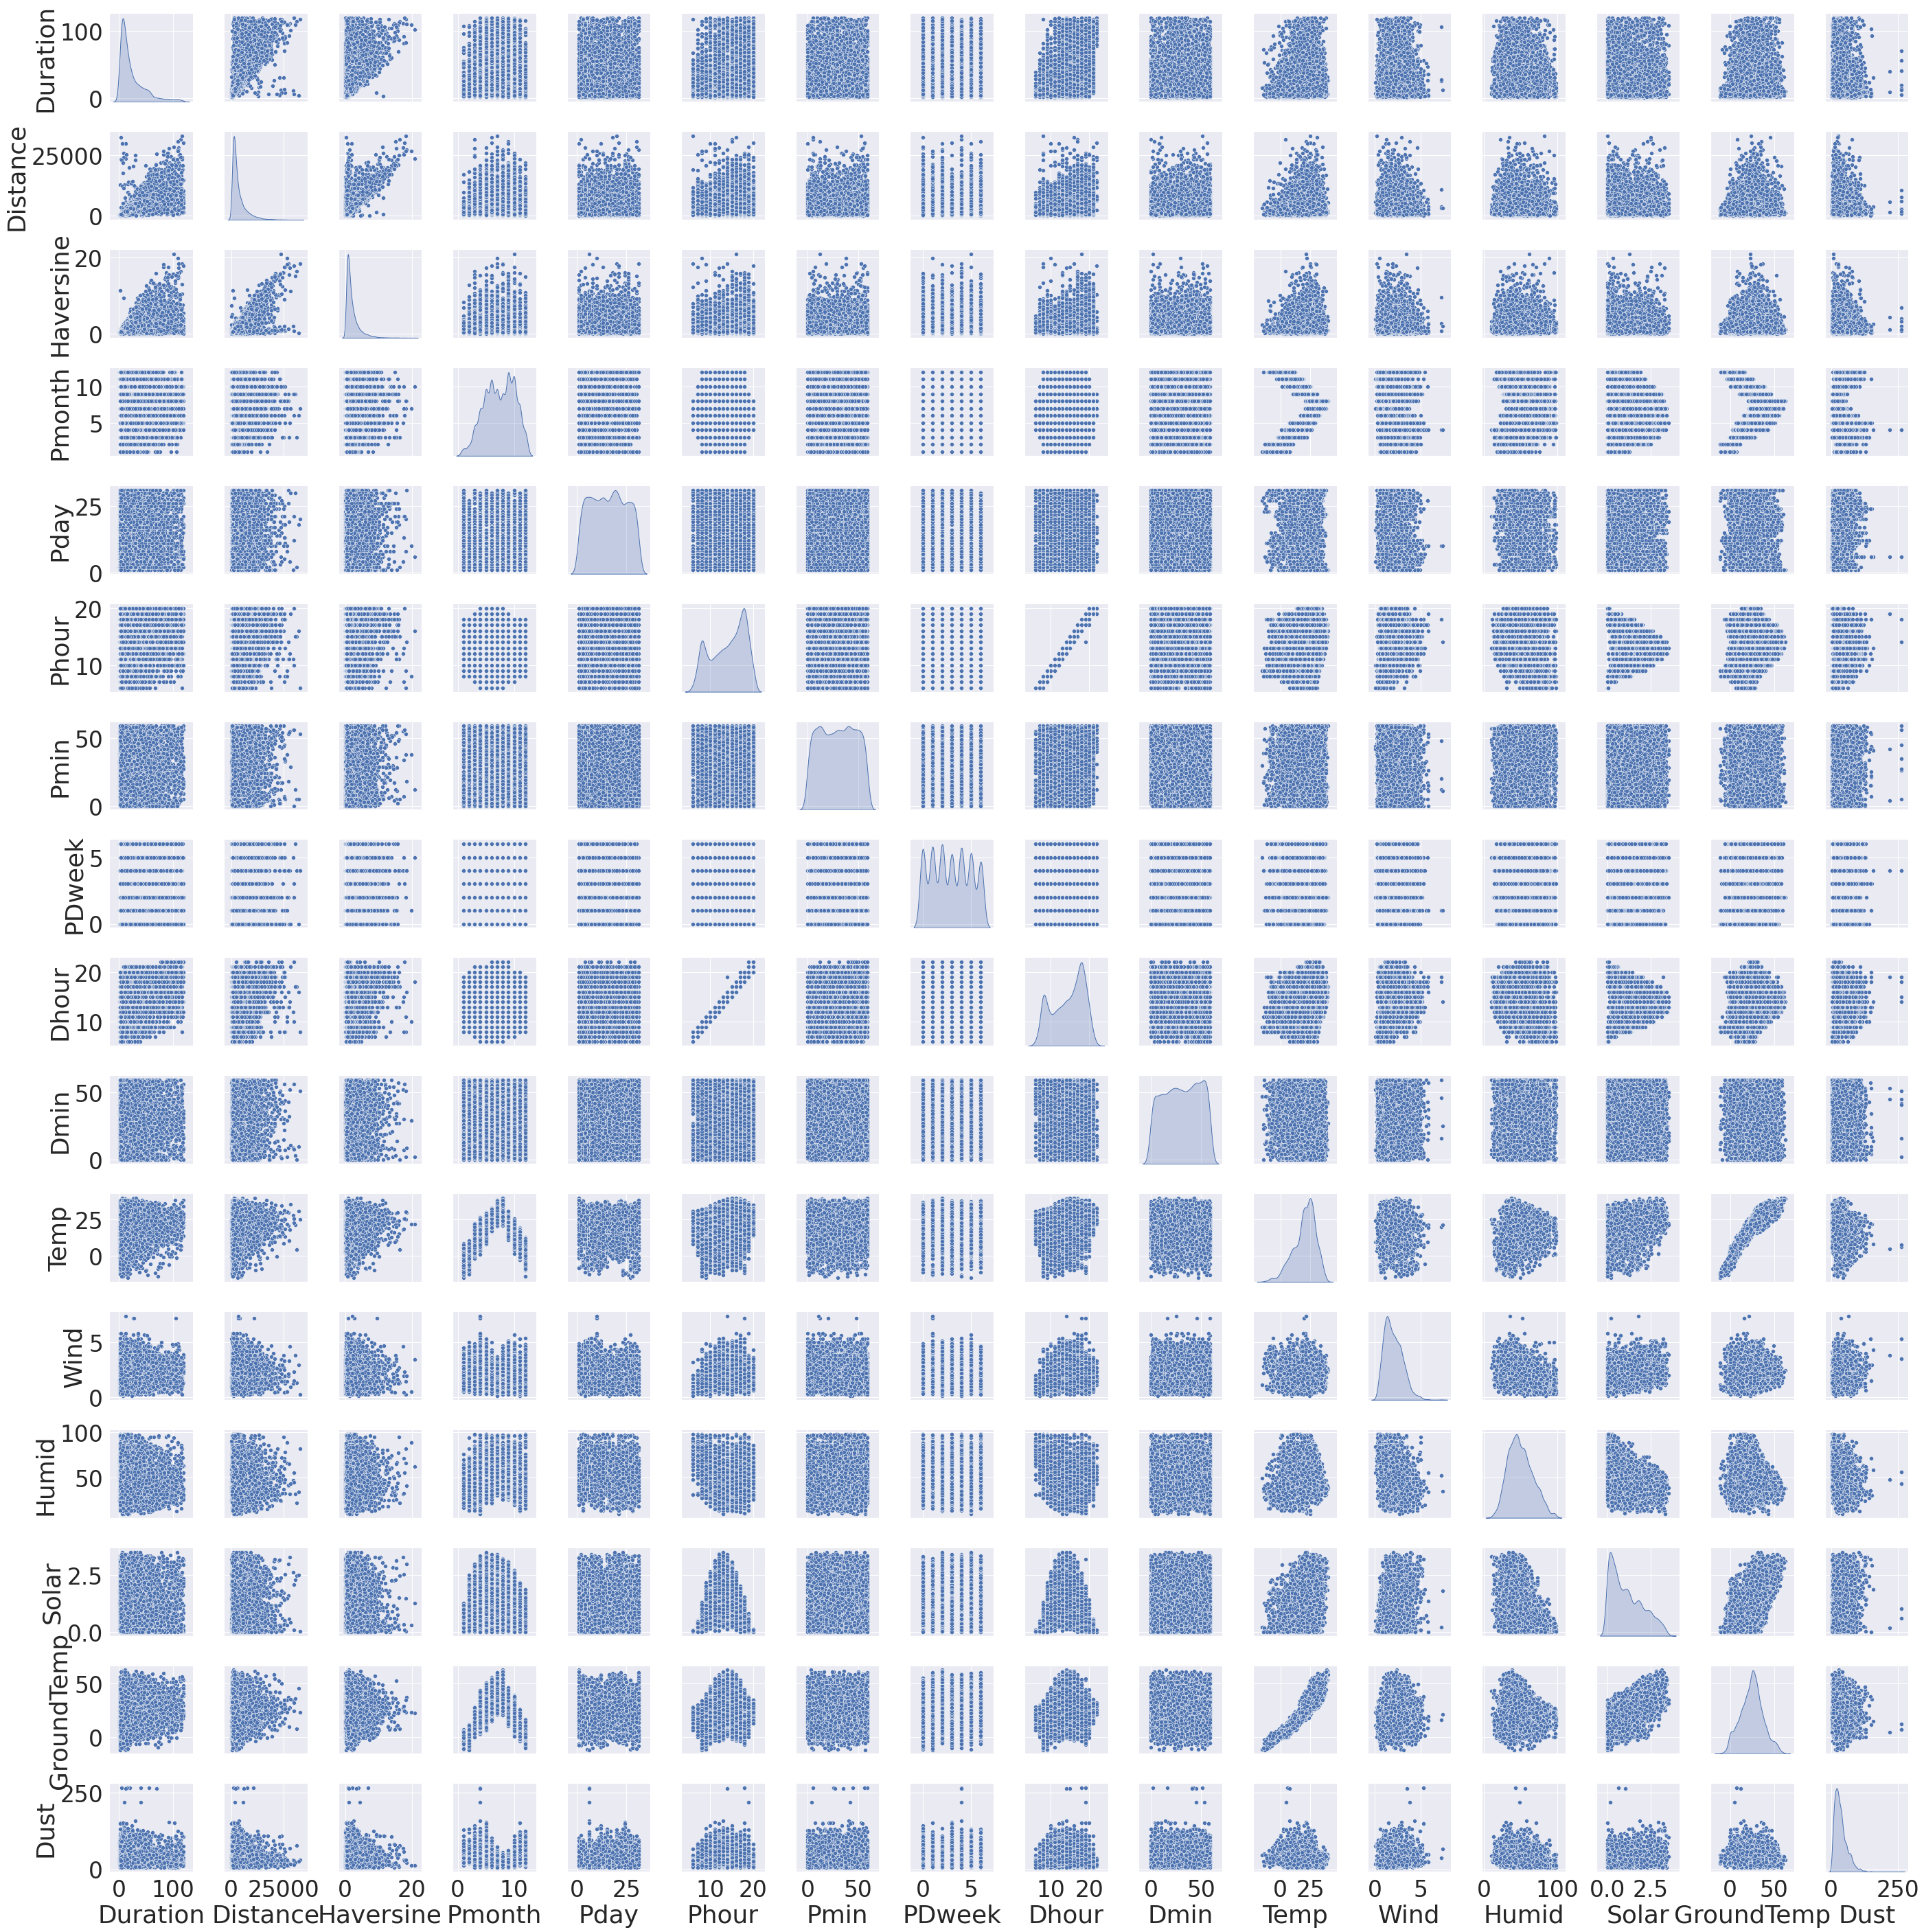

In [55]:
sns.set(font_scale=3)
sns.pairplot(sampling,diag_kind='kde')

### Feature Engineering

In [56]:
df_sample=df.sample(n=53609,replace=True,random_state=101)
df_sample.reset_index(drop=True,inplace=True)
df_sample

Duration  Distance  Haversine  Pmonth  Pday  Phour  Pmin  PDweek  \
0            44      4990   1.501776       9     4     13    22       1   
1             6      1540   1.301194       6     5      7    36       1   
2            17      2400   1.929334      11    10     12    39       5   
3             4       600   0.511734       3    20     15    23       1   
4            10      1700   1.348312       9    27     11    49       3   
...         ...       ...        ...     ...   ...    ...   ...     ...   
53604        33      6660   4.566863      12    31     18    14       0   
53605        45      5650   2.762302      10     9     12    47       1   
53606         7       880   0.683929       7    13     18    22       4   
53607         6      1540   1.185821       2     8     18     9       3   
53608        33      6980   3.892900       4    11     17    42       2   

       Dhour  Dmin  Temp  Wind  Humid  Solar  GroundTemp  Dust  
0         14     7  26.5   2.8   58.0   2.87        34.3  17.0  
1          7    43  18.8   0.7   64.0   0.48        18.0  24.0  
2         12    56  15.1   2.2   54.0   1.91        20.2  64.0  
3         15    28   6.5   3.3   39.0   1.21        10.7  20.0  
4         12     0  21.3   1.7   43.0   2.42        29.9  24.0  
...      ...   ...   ...   ...    ...    ...         ...   ...  
53604     18    49  -2.4   1.7   27.0   0.02        -1.4  49.0  
53605     13    33  18.3   0.6   40.0   1.82        24.1  24.0  
53606     18    30  30.8   2.5   60.0   1.43        30.7  16.0  
53607     18    16  -0.5   1.7   26.0   0.15        -0.5  45.0  
53608     18    17  16.2   4.1   22.0   1.73        18.1  45.0  

[53609 rows x 16 columns]

In [57]:
X = df_sample.drop(labels=["Duration"], axis = 1)
y = df_sample["Duration"]

In [58]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=101)

In [59]:
from sklearn.feature_selection import RFE
from sklearn.ensemble import RandomForestRegressor
rfe=RFE(estimator=RandomForestRegressor(),n_features_to_select=10)
X_train_rfe=rfe.fit_transform(X_train,y_train)
X_test_rfe=rfe.transform(X_test)

<AxesSubplot:>

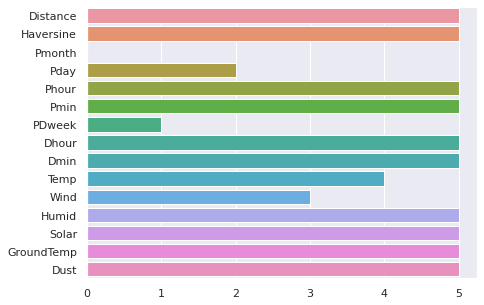

In [60]:
sns.set()
plt.figure(figsize=(7,5))
sns.barplot(y=X_train.columns,x=max(rfe.ranking_)-rfe.ranking_)

In [61]:
feature_list_rfe=[col for i,col in enumerate(X_train.columns) if rfe.support_[i]]
feature_list_rfe

['Distance',
 'Haversine',
 'Phour',
 'Pmin',
 'Dhour',
 'Dmin',
 'Humid',
 'Solar',
 'GroundTemp',
 'Dust']

### Modelling

In [62]:
X_train_rfe.shape

(40206, 10)

In [63]:
X_test_rfe.shape

(13403, 10)

In [64]:
y_train.shape

(40206,)

In [65]:
y_test.shape

(13403,)

In [66]:
rf = RandomForestRegressor(n_estimators=200, n_jobs=-1)

rf.fit(X_train_rfe, y_train)
y_hat_test = rf.predict(X_test_rfe)


#rf.fit(X_train, y_train)
#y_hat_test = rf.predict(X_test)

In [67]:
y_hat_train = rf.predict(X_train_rfe)

In [68]:
y_hat_train

array([ 6.56 ,  9.685, 11.805, ...,  5.385, 32.915,  9.895])

In [69]:
from sklearn.metrics import classification_report, mean_absolute_error, mean_squared_error, r2_score
print(f'Training score : {rf.score(X_train_rfe, y_train)}')

print()
print('r2 score:', r2_score(y_test, y_hat_test))
print('MAE:', mean_absolute_error(y_test, y_hat_test))
print('MSE:', mean_squared_error(y_test, y_hat_test))
print('RMSE:', np.sqrt(mean_squared_error(y_test, y_hat_test)))

Training score : 0.9661618995823823

r2 score: 0.7464021612949936
MAE: 6.339111019920913
MSE: 139.11481662500933
RMSE: 11.79469442694508


/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0.5, 1.0, 'Error rate Distribution')

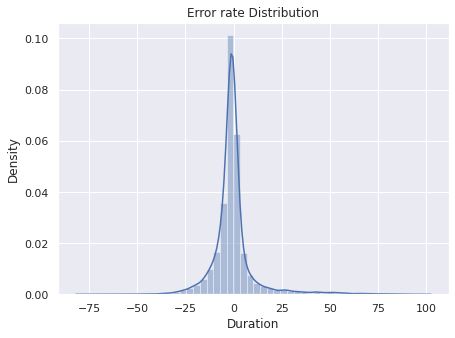

In [70]:
plt.figure(figsize=(7,5))
sns.distplot(y_test-y_hat_test)
plt.title("Error rate Distribution")

In [71]:
from xgboost import XGBRegressor
xgb = XGBRegressor()

xgb.fit(X_train_rfe, y_train)
y_hat_test_xgb = xgb.predict(X_test_rfe)

In [72]:
print(f'Training score : {xgb.score(X_train_rfe, y_train)}')

print()
print('r2 score:', r2_score(y_test, y_hat_test_xgb))
print('MAE:', mean_absolute_error(y_test, y_hat_test_xgb))
print('MSE:', mean_squared_error(y_test, y_hat_test_xgb))
print('RMSE:', np.sqrt(mean_squared_error(y_test, y_hat_test_xgb)))

Training score : 0.9782603414253052

r2 score: 0.9366865226354358
MAE: 3.050012411555385
MSE: 34.731537297163655
RMSE: 5.893346867202341


#### Feature Importance

Text(0.5, 1.0, 'Visualizing important Features')

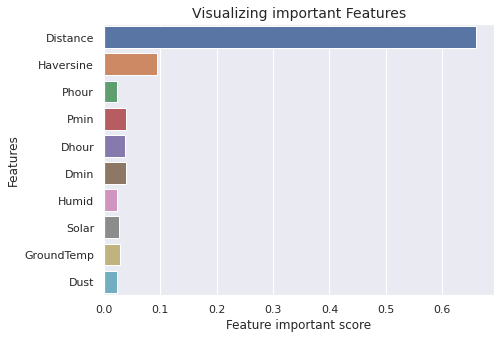

In [73]:
plt.figure(figsize=(7,5))
sns.barplot(x=rf.feature_importances_,y=feature_list_rfe)
plt.xlabel("Feature important score")
plt.ylabel("Features")
plt.title("Visualizing important Features",size=14)

### HyperParameter Tuning

In [74]:
from sklearn.model_selection import RandomizedSearchCV
from pprint import pprint
# number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# number of features at every split
max_features = ['auto', 'sqrt']
#Maximum number of levels in Tree
max_depth = [int(x) for x in np.linspace(10, 100, num = 11)]
max_depth.append(None)

#Minimum number of samples required to split a node
min_samples_split=[2,5,10]

#Minimum number of samples required at each leaf node
min_samples_leaf=[1,2,4]
#Method of Selecting samples for training each tree
bootstrap=[True,False]
#Create the random Grid
random_grid={'n_estimators':n_estimators,
             'max_features':max_features,
             'max_depth':max_depth,
             'min_samples_split':min_samples_split,
             'min_samples_leaf':min_samples_leaf,
             'bootstrap':bootstrap}
pprint(random_grid)


{'bootstrap': [True, False],
 'max_depth': [10, 19, 28, 37, 46, 55, 64, 73, 82, 91, 100, None],
 'max_features': ['auto', 'sqrt'],
 'min_samples_leaf': [1, 2, 4],
 'min_samples_split': [2, 5, 10],
 'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000]}


In [75]:
params={'bootstrap': [True, False],
 'max_depth': [10,50,100, None],
 'max_features': ['auto', 'sqrt'],
 'min_samples_leaf': [1, 2, 4],
 'min_samples_split': [2, 5, 10],
 'n_estimators': [200, 1000, 2000]}

In [76]:

from sklearn.model_selection import RandomizedSearchCV
rf_random=RandomizedSearchCV(estimator=rf, param_distributions=params, n_iter=1, cv=3, verbose=2,random_state=42, n_jobs = -1)
rf_random.fit(X_train_rfe, y_train)

Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   15.8s finished


RandomizedSearchCV(cv=3,
                   estimator=RandomForestRegressor(n_estimators=200, n_jobs=-1),
                   n_iter=1, n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [10, 50, 100, None],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [200, 1000, 2000]},
                   random_state=42, verbose=2)

In [77]:
rf_random.best_params_

{'n_estimators': 200,
 'min_samples_split': 5,
 'min_samples_leaf': 4,
 'max_features': 'sqrt',
 'max_depth': 50,
 'bootstrap': True}

### Explainable AI

In [78]:
df1=pd.read_csv("../input/seoul-bike-trip-duration-prediction/For_modeling.csv",nrows=1000,index_col=[0])
X=df1.drop(labels=['Duration'],axis=1)
y=df1['Duration']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=101)


In [79]:
rf1 = RandomForestRegressor(n_estimators=200, n_jobs=-1)
xgb1 = XGBRegressor()
rf1.fit(X_train, y_train)
xgb1.fit(X_train, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=100, n_jobs=4, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

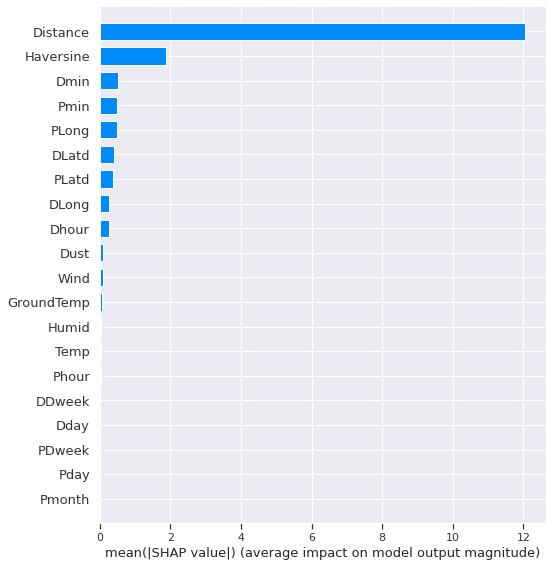

In [80]:
import shap
shap_values=shap.TreeExplainer(rf1).shap_values(X_train)
shap.summary_plot(shap_values,X_train,plot_type='bar')

ntree_limit is deprecated, use `iteration_range` or model slicing instead.


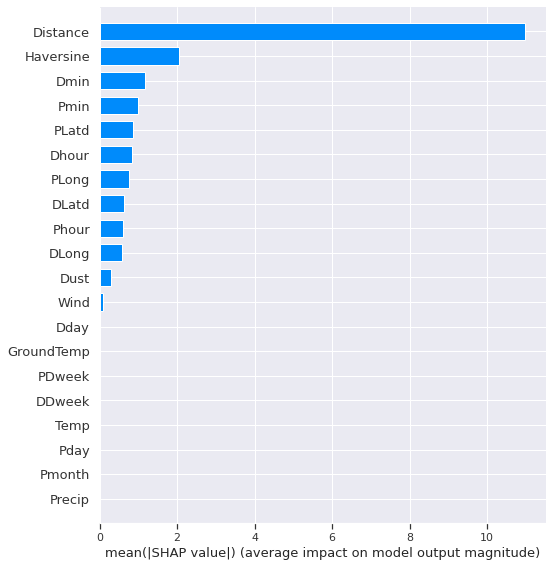

In [81]:
import shap
shap_values=shap.TreeExplainer(xgb1).shap_values(X_train)
shap.summary_plot(shap_values,X_train,plot_type='bar')

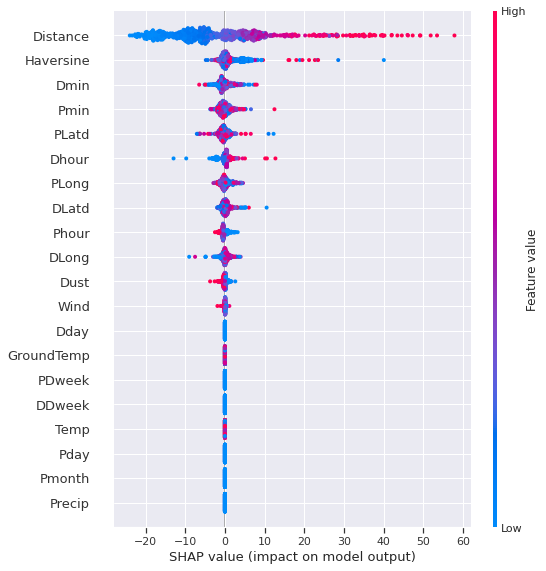

In [82]:
shap.summary_plot(shap_values, X_train)

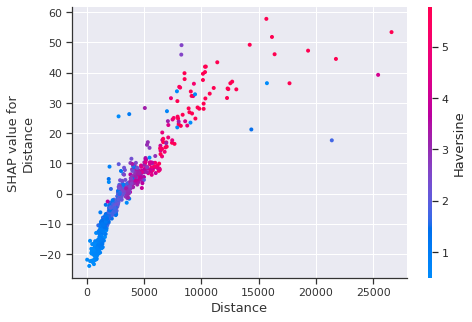

In [83]:
shap.dependence_plot("Distance", shap_values, X_train)

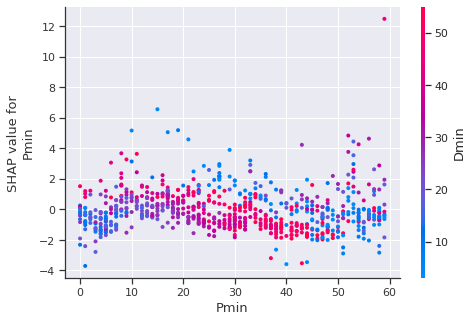

In [84]:
shap.dependence_plot("Pmin", shap_values, X_train)

In [85]:
shap.initjs()
def shap_plot(j):
    explainerModel=shap.TreeExplainer(rf1)
    shap_values_Model=explainerModel.shap_values(S)
    p=shap.force_plot(explainerModel.expected_value,shap_values_Model[j],S.iloc[[j]])
    return(p)
X_output=X_test.copy()
X_output.loc[:,'predict']=np.round(rf1.predict(X_output),2)
random_picks=np.arange(1,50)
S=X_output.iloc[random_picks]
S

Distance      PLong       PLatd      DLong       DLatd  Haversine  \
300       3920  37.520077  127.112366  37.533764  127.138031   2.727391   
110       4950  37.516571  127.131538  37.546631  127.155884   3.972570   
845       1960  37.595299  127.080032  37.602077  127.079582   0.754722   
196        570  37.555496  126.936340  37.559177  126.934525   0.439467   
609       1190  37.499413  127.112869  37.493729  127.120621   0.931220   
248       4080  37.569805  127.016953  37.560356  127.041397   2.397036   
697       2070  37.521362  126.923462  37.520271  126.938881   1.365239   
810       3010  37.552746  126.918617  37.568199  126.917847   1.719638   
409       7190  37.576508  127.002457  37.555054  126.937569   6.196771   
832       1730  37.569122  126.914795  37.557499  126.923805   1.516918   
987       1960  37.536808  127.055489  37.548222  127.067879   1.674553   
749       2880  37.508091  127.063103  37.494007  127.079514   2.132707   
343       2010  37.480251  126.914604  37.464886  126.919479   1.761846   
605       2010  37.558052  127.040352  37.542816  127.044670   1.736407   
321       7480  37.636261  127.032173  37.598591  127.079819   5.929295   
122       3160  37.561096  127.036797  37.582592  127.028976   2.487650   
301       5560  37.513126  127.100960  37.497700  127.146202   4.343836   
32        2030  37.569805  127.016953  37.554295  127.011200   1.797640   
271       5920  37.639278  127.026756  37.590382  127.017136   5.502626   
895       1110  37.584171  126.911102  37.590797  126.913651   0.770252   
672       5670  37.512169  127.078934  37.486767  127.046761   4.004218   
828       2330  37.513126  127.100960  37.505692  127.084038   1.706230   
761       1460  37.576382  127.035110  37.575272  127.023468   1.033376   
738       6700  37.589912  127.068680  37.548222  127.067879   4.636260   
227       3870  37.532543  126.868729  37.524063  126.875580   1.119874   
573       4300  37.539654  127.052589  37.556030  127.078644   2.931227   
56        2840  37.530235  127.086830  37.536667  127.073593   1.368900   
411       4410  37.599098  127.092949  37.614738  127.076363   2.271379   
741       3680  37.550629  126.914986  37.530079  126.905708   2.427071   
36        2880  37.477509  127.126328  37.495670  127.130592   2.054161   
416       8740  37.535080  126.985382  37.520271  126.938881   4.418933   
136       3640  37.508339  127.088142  37.502396  127.058800   2.671306   
608       1450  37.558533  127.006989  37.560474  127.014076   0.660929   
378       2270  37.530773  127.120926  37.534481  127.138344   1.590272   
931       8170  37.580589  126.923447  37.636234  126.918999   6.199844   
569       4400  37.483990  127.034180  37.485611  126.994682   3.489762   
139       1670  37.535080  126.985382  37.536758  126.970001   1.368987   
887       7300  37.556000  126.910454  37.611179  126.929665   6.364880   
133        980  37.529770  127.074860  37.536667  127.073593   0.775007   
423       8180  37.560356  127.041397  37.596020  127.059830   4.285457   
203       5420  37.569183  127.009880  37.562138  126.963776   4.138396   
982       1030  37.574188  127.045891  37.580406  127.044823   0.697788   
293       3810  37.511982  127.085052  37.496117  127.069443   2.237845   
498       2070  37.500614  126.986160  37.504116  126.997490   1.072646   
140         10  37.575970  126.983063  37.575970  126.983063   0.000000   
1007      1700  37.543915  127.125458  37.530773  127.120926   1.514976   
938        820  37.520294  126.901192  37.528263  126.896629   0.973204   
628       2120  37.656830  127.039848  37.654049  127.057327   1.569494   
912       2140  37.560356  127.041397  37.549583  127.030243   1.549758   

      Pmonth  Pday  Phour  Pmin  ...  DDweek  Temp  Precip  Wind  Humid  \
300        1     1      1     9  ...       0  -3.3     0.0   0.7   41.0   
110        1     1      0    32  ...       0  -3.2     0.0   0.5   40.0   
845        1     1      3    3

In [86]:
shap_plot(0)

In [87]:
shap_plot(3)

In [88]:
import joblib

# use only either one of these
with open('../final_model_best.pkl.compressed', 'wb') as m:
    joblib.dump(xgb, m, compress=('zlib', 6))


with open("../final_model_best.joblib", 'wb') as x:
    joblib.dump(xgb, x, compress=3)